In [ ]:
import os
import data_loader as loader
import pandas as pd
import psycopg2
import plot
import numpy as np
import my_module as mod
from connection import SQL_connection
from datetime import datetime, timedelta
from sqlalchemy import create_engine, text # для удобства будем использовать эту библиотеку, а не psycopg2

# Работать будем с локально установленной СУБД Postgresql
# сгенерируем "удобный" датасет для текущего ДЗ: достаточно наблюдений и немного столбцов
# Параметры датасета
num_rows = 1000
regions = ['East', 'West', 'North', 'South']
products = ['Notebook', 'Smartphone', 'Chair', 'Table', 'Monitor', 'Printer']

# Генерация данных
# для csv-файла
np.random.seed(42)
order_ids = np.arange(1, num_rows + 1)
order_dates = [datetime(2023, 1, 1) + timedelta(days=np.random.randint(0, 365)) for _ in range(num_rows)]
regions_data = np.random.choice(regions, num_rows)
products_data = np.random.choice(products, num_rows)
quantities = np.random.randint(1, 10, num_rows)
prices = np.random.randint(100, 2000, num_rows)

# Создание DataFrame
data = {
    "OrderID": order_ids,
    "OrderDate": order_dates,
    "Region": regions_data,
    "Product": products_data,
    "Quantity": quantities,
    "Price": prices
}

df = pd.DataFrame(data)

# для справочника регионов
data_regions = {"Title": regions}
df_regions = pd.DataFrame(data_regions)

# Сохранение в CSV
df.to_csv("sales_data_1000.csv", index=False)
csv_file_path = 'sales_data_1000.csv' # представим, что нашли где-то датасет в формате csv и создали на его основании датафрейм


In [21]:
# Загрузка переменных среды
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST")
db_port = os.getenv("DB_PORT")
db_name = os.getenv("DB_NAME")

# Проверка, что переменные загружены
if not all([db_user, db_password, db_host, db_port, db_name]):
    raise ValueError("Не все переменные среды заданы!")

In [22]:
# попробуем работать через psycopg2
# для psycopg2
db_config = {
    'dbname': db_name,
    'user': db_user,
    'password': db_password,
    'host': db_host,  
    'port': db_port
}

create_table_query = """
CREATE TABLE IF NOT EXISTS sales_psycopg2 (
                           OrderID  INT8 PRIMARY KEY,
                           OrderDate DATE,
                           Region VARCHAR(100),
                           Product VARCHAR(100),
                           Quantity INT8,
                           Price DECIMAL(24,2) 
);
"""
# Имя таблицы в PostgreSQL
table_name = 'sales_psycopg2'
try: 
    # Подключение к базе данных
    conn = psycopg2.connect(**db_config)
    print("Подключение к базе данных успешно установлено!")

    try:
        cursor = conn.cursor()
        cursor.execute(create_table_query)
    except Exception as e:
        print(f"Неуспешное создание таблицы : {e}")
    finally:
        # Закрываем курсор
        cursor.close()  
      
    loader.load_csv_into_bd(conn, table_name, csv_file_path)
    
except Exception as e:
    print(f"Ошибка : {e}")
    
finally:
    # Закрытие соединения
    if conn:
        conn.close()
        print("Соединение с базой данных закрыто.")

Подключение к базе данных успешно установлено!
Данные из sales_data_1000.csv успешно загружены в таблицу sales_psycopg2
Соединение с базой данных закрыто.


In [23]:
# пробуем работать через sqlalchemy
# т.к. с sqlalchemy работать проще, то основной код для ДЗ будет начинаться в этой клетке
# Строка подключения (используем f-строку)
DATABASE_URL = f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
conn_sql = SQL_connection(DATABASE_URL)

Подключение к базе данных успешно установлено!


In [24]:
# Загружаем DataFrame(датасета) в PostgreSQL    
# Имя таблицы в PostgreSQL, куда будут загружены данные
table_name = 'sales_sqlalchemy'
df.to_sql(table_name, conn_sql.engine, if_exists='replace', index=False)
print(f'Данные из {csv_file_path} успешно загружены в таблицу {table_name}')

# Загружаем DataFrame(справочника регионов) в PostgreSQL
dict_name = 'dict_regions' 
df_regions.to_sql(dict_name, conn_sql.engine, if_exists='replace', index=True)
print(f'Данные успешно загружены в таблицу {dict_name}')

Данные из sales_data_1000.csv успешно загружены в таблицу sales_sqlalchemy
Данные успешно загружены в таблицу dict_regions


In [25]:
 # убедимся что между загрузкой через sqlalchemy И psycopg2 разницы в данных нет
check_query = """
SELECT * FROM sales_psycopg2
EXCEPT
SELECT * FROM sales_sqlalchemy
UNION
SELECT * FROM sales_sqlalchemy
EXCEPT
SELECT * FROM sales_psycopg2
;
"""
results = conn_sql.connection.execute(text(check_query)).fetchall()
df_results = pd.DataFrame(results)
if not df_results.empty:
    mod.statistic_dataF(df_results) 
else: 
    print ('Выборка с расхождениями пуста - расхождений нет')

    

Выборка с расхождениями пуста - расхождений нет


Максимальное число проданных единиц товара 


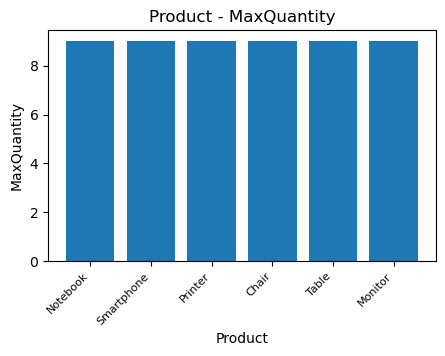

In [26]:
# Паработаем с SQL, найдем максимальное количество проданных единиц каждого товара
max_quantity_product = """
SELECT "Product", MAX("Quantity") as "MaxQuantity" FROM sales_sqlalchemy
GROUP BY "Product";
"""
print ('Максимальное число проданных единиц товара ')
results = conn_sql.connection.execute(text(max_quantity_product)).fetchall()
df_max = pd.DataFrame(results)
plot.bar (df_max,'Product', 'MaxQuantity')

   

In [27]:
# проведем небольшую обработку исходного датасета: посморим, за каждый-ли день
# по всем-ли раегионам из справочника у нас есть информация по продажам
# проведем небольшую обработку исходного датасета на стороне БД
join_tables_query = """
SELECT rd."OrderDate", rd."Region", s."Product", s."Quantity" * s."Price" AS "Amount"
   , SUM(s."Quantity" * s."Price") OVER (PARTITION BY  s."OrderDate", rd."Region") as "TotalByRegion"
   , SUM(s."Quantity" * s."Price") OVER (PARTITION BY  s."OrderDate") as "TotalZaDen"
FROM (SELECT d."OrderDate", r."Title" AS "Region", r."index" AS "RegionCode" 
      FROM dict_regions r
      CROSS JOIN (SELECT DISTINCT "OrderDate" FROM sales_sqlalchemy)d
     )rd 
LEFT JOIN sales_sqlalchemy s ON rd."Region" = s."Region" and s."OrderDate" = rd."OrderDate"
ORDER BY 1, 2, 3;
""" 

results = conn_sql.connection.execute(text(join_tables_query)).fetchall()

#посмотрим результат
print ('Посмотрим статистику по "обработанному датасету"\n')
df_results = pd.DataFrame(results)
mod.statistic_dataF(df_results) # видим, информация за каждый из анализщируемых дней есть не по всем регионам    

Посмотрим статистику по "обработанному датасету"

   OrderDate Region   Product  Amount  TotalByRegion  TotalZaDen
0 2023-01-01   East      None     NaN            NaN         NaN
1 2023-01-01  North   Monitor  5064.0         5864.0     24990.0
2 2023-01-01  North  Notebook   800.0         5864.0     24990.0
3 2023-01-01  South     Chair  7305.0        12441.0     24990.0
4 2023-01-01  South   Monitor  2412.0        12441.0     24990.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1613 entries, 0 to 1612
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   OrderDate      1613 non-null   datetime64[ns]
 1   Region         1613 non-null   object        
 2   Product        1000 non-null   object        
 3   Amount         1000 non-null   float64       
 4   TotalByRegion  1000 non-null   float64       
 5   TotalZaDen     1000 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object

Датасет до обработки 



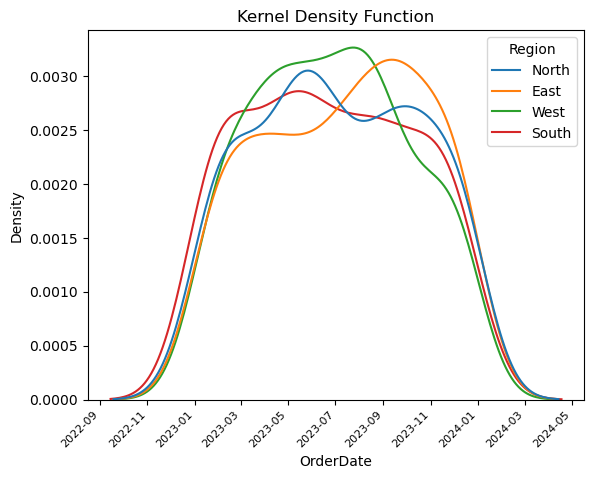

Датасет после обработки 



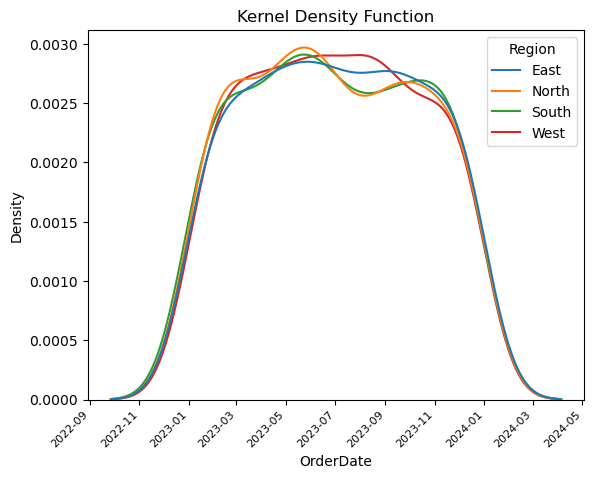

Соединение с базой данных закрыто


In [28]:
# сравним частоту появления наблюдений по продажам в каждам регионе за каждый день наблюдений 
# для первоначального датасета и после того как добавили в БД 
# строки для каждого региона, по которому наблюдение отсутствовало
print ('Датасет до обработки \n')
plot.kde (df, 'OrderDate', 'Region')
print ('Датасет после обработки \n')
plot.kde (df_results, 'OrderDate', 'Region')
# выполнено в качестве тренировки посторения графиков и демонстрации отличий до и после    
conn_sql.close()